In [183]:
import os
import pandas as pd
import csv
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.stats
import dash_bio
import seaborn as sns
from adjustText import adjust_text

In [31]:
# declare CSV variable names
pd.options.display.max_rows = 9999
pd.options.display.max_columns = 9999
model = '/Users/connormullins/Excel sheets/Model.csv'
osm = '/Users/connormullins/Excel sheets/OmicsSomaticMutations.csv'
effect = '/Users/connormullins/Excel sheets/CRISPRGeneEffect.csv'

In [233]:
# convert CSVs to pandas dataframes
model_df = pd.read_csv(model, header=0, index_col=0)
osm_df = pd.read_csv(osm, header=0)
effect_df = pd.read_csv(effect, header=0, index_col=0)

/var/folders/k9/bz30f50d0bv1pzq8kv4wkg4h0000gn/T/ipykernel_3172/3585096085.py:3: DtypeWarning: Columns (20,48,52,54,55,56,57,59) have mixed types. Specify dtype option on import or set low_memory=False.
  osm_df = pd.read_csv(osm, header=0)


In [479]:
# filter model.csv to only keep indices which contain cancer type declared
cancer = "Non-Small Cell Lung Cancer"
filter_model = model_df[model_df["OncotreePrimaryDisease"] == cancer]

In [480]:
# filter the OmicsSomaticMutations.csv to only include model ids that have declared cancer type
osm_filter = pd.merge(filter_model, osm_df, on=['ModelID'], how='inner')


In [481]:
# filter that dataframe to only include the gene and mutation declared
gene = 'KRAS'
mutation = "p.G12C"
osm_gene_filter = osm_filter[(osm_filter['HugoSymbol'] == gene)]
osm_mutant_filter = osm_gene_filter[(osm_gene_filter['ProteinChange'] == mutation)]

In [507]:
# filter such that another dataframe is created for all modelIDs that have a mutation in another gene
comutation_gene = "SMARCA4"
osm_filter = pd.merge(filter_model, osm_df, on=['ModelID'], how='inner')
osm_comutant = osm_filter[(osm_filter['HugoSymbol'] == comutation_gene)]


In [508]:
# compare the two dataframes. The models that have a mutation for both the gene and comutant gene will be in a comutant dataframe.
# the models that only have the gene mutation will be under no_comutation

comutant = osm_mutant_filter.merge(osm_comutant, on=['ModelID'], how='inner')
no_comutant = osm_mutant_filter.merge(osm_comutant, on=['ModelID'], how='left')

In [509]:
# merge the left and inner parts to make a new merged dataframe with duplicates of the comutants that can be dropped
no_comutant = pd.concat([no_comutant, comutant])
no_comutant = no_comutant.drop_duplicates(keep =  False)
# filter the dataframes just created to only include the model ids of the ones that match the parameters
comutant_filter = comutant.filter(['ModelID'])
no_comutant_dropped = no_comutant.filter(['ModelID'])

In [510]:
# using CRISPRGeneEffect.csv, filter into two dataframes for mutant and comutant and average the values over the row
comutant_effect = comutant_filter.merge(effect_df, on=['ModelID'], how='inner')
comutant_effect = comutant_effect.set_index('ModelID')

comutant_effect = comutant_effect.drop_duplicates(keep =  False)
no_comutant_effect = no_comutant_dropped.merge(effect_df, on=['ModelID'], how='left')
no_comutant_effect = no_comutant_effect.set_index('ModelID')
no_comutant_effect = no_comutant_effect.drop_duplicates(keep =  False)

In [511]:
# t-test to get p-values
p_val = scipy.stats.ttest_ind(no_comutant_effect, comutant_effect, axis = 0, equal_var = True, nan_policy = 'omit')
pvalue = p_val.pvalue
print(pvalue)

[0.68521435 0.96533476 0.55960038 ... 0.12157186 0.35749339 0.45721377]


In [512]:
# convert pvalues to be used for yaxis
yaxis = -np.emath.logn(10, pvalue)
yaxis = pd.DataFrame(yaxis)
yaxis.rename(columns = {0 : 'nlogpvalue'}, inplace =True)

In [513]:
# find the mean of the dataframes
comutant_mean = comutant_effect.mean(axis = 0, skipna = True)
comutant_mean = comutant_mean.reset_index(drop = True)
no_comutant_mean = no_comutant_effect.mean(axis = 0, skipna = True)
no_comutant_mean = no_comutant_mean.reset_index(drop = True)

In [514]:
# calculate fold change
fold_change =  comutant_mean / no_comutant_mean
# fold_change = fold_change.to_numpy()
# for i, val in enumerate(fold_change):
#     if fold_change[i] < 0:
#         fold_change[i] = -1/val
        
# fold_change = pd.DataFrame(fold_change)
print(fold_change)

0        1.831191
1        1.067645
2       -2.191778
3        0.043089
4       -0.247227
           ...   
16378    1.973972
16379    7.665320
16380   -6.183148
16381    0.470441
16382   -0.223515
Length: 16383, dtype: float64


In [515]:
xaxis = fold_change
xaxis = np.log2(xaxis)
xaxis = pd.DataFrame(xaxis)
xaxis.rename(columns = {0 : 'log2FC'}, inplace= True)
print(xaxis)

         log2FC
0      0.872783
1      0.094433
2           NaN
3     -4.536549
4           NaN
...         ...
16378  0.981102
16379  2.938346
16380       NaN
16381 -1.087914
16382       NaN

[16383 rows x 1 columns]


/opt/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [516]:
volcano = pd.concat([xaxis, yaxis], axis =1)
volcano = volcano.set_index(no_comutant_effect.columns)
volcano = volcano.reset_index()
volcano.rename(columns = {'index' : 'symbol'}, inplace =True)
print(volcano)

                   symbol    log2FC  nlogpvalue
0                A1BG (1)  0.872783    0.164174
1            A1CF (29974)  0.094433    0.015322
2                 A2M (2)       NaN    0.252122
3          A2ML1 (144568) -4.536549    0.577887
4        A3GALT2 (127550)       NaN    0.729598
...                   ...       ...         ...
16378   TNFAIP8L2 (79626)  0.981102    0.921225
16379  TNFAIP8L3 (388121)  2.938346    0.495740
16380    TNFRSF10A (8797)       NaN    0.915167
16381    TNFRSF10B (8795) -1.087914    0.446732
16382    TNFRSF10C (8794)       NaN    0.339881

[16383 rows x 3 columns]


([Text(3.6069989431385494, 5.205965210196149, 'ASF1B (55723)'),
  Text(5.462669461405351, 6.365904942170745, 'ESR2 (2100)'),
  Text(9.377478582195938, 6.132421086018979, 'KCNG3 (170850)'),
  Text(4.401229231962734, 7.033171089631207, 'KHDC4 (22889)'),
  Text(4.755523180925131, 6.578788137621089, 'MSH2 (4436)'),
  Text(10.037564050009511, 5.36596952015517, 'MSH6 (2956)'),
  Text(4.109375010671826, 6.043840380883218, 'MUC1 (4582)'),
  Text(11.19615821935243, 5.099358606956702, 'PLEK2 (26499)'),
  Text(6.244366323842399, 6.822251340017134, 'PPP2R5E (5529)'),
  Text(5.222276205458574, 4.8927723755317825, 'RAB15 (376267)'),
  Text(4.871013378483898, 5.439145002165189, 'RHOJ (57381)'),
  Text(5.065770992216137, 5.779667661090631, 'SGPP1 (81537)')],
  <matplotlib.patches.FancyArrowPatch at 0x29730f9d0>])

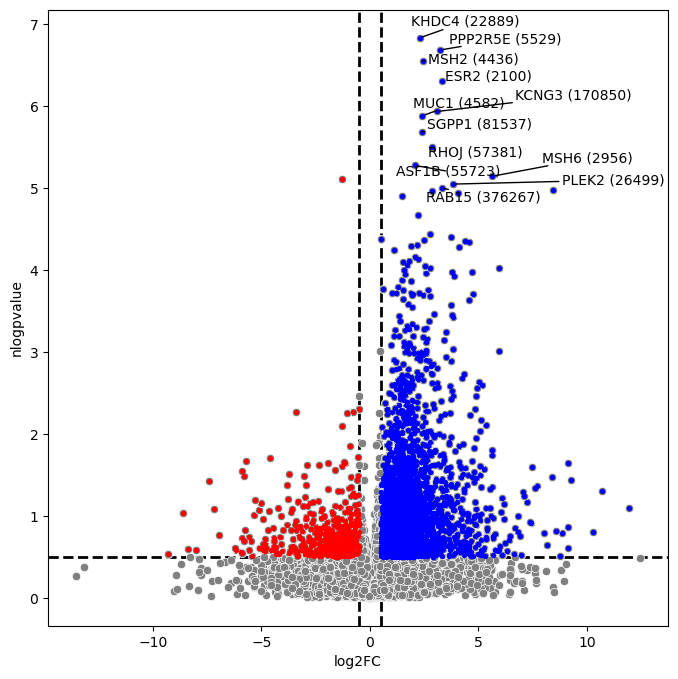

In [518]:
plt.figure(figsize = (8, 8))
point_size = 8
ax = sns.scatterplot(data = volcano, x = 'log2FC', y = 'nlogpvalue', c = 'gray')

ax.axhline(0.5, zorder = 0, c = 'k', lw = 2, ls = '--')
ax.axvline(0.5, zorder = 0, c = 'k', lw = 2, ls = '--')
ax.axvline(-0.5, zorder = 0, c = 'k', lw = 2, ls = '--')




# Conditions for coloring
condition1 = (volcano['nlogpvalue'] > 0.5) & (volcano['log2FC'] > 0.5)
condition2 = (volcano['nlogpvalue'] > 0.5) & (volcano['log2FC'] < -0.5)

# Apply color based on conditions
ax.scatter(volcano.loc[condition1, 'log2FC'], volcano.loc[condition1, 'nlogpvalue'], c='blue', s = point_size)
ax.scatter(volcano.loc[condition2, 'log2FC'], volcano.loc[condition2, 'nlogpvalue'], c='red', s = point_size)

texts = []

for i in range(len(volcano)):
    if volcano.iloc[i].nlogpvalue > 5 and (volcano.iloc[i].log2FC > 2 or volcano.iloc[i].log2FC < -2):
        texts.append(plt.text(volcano.iloc[i].log2FC, y = volcano.iloc[i].nlogpvalue, s = volcano.iloc[i].symbol))
        
#     if (volcano.iloc[i].symbol == 'KRAS (3845)'):
#         texts.append(plt.text(volcano.iloc[i].log2FC, y = volcano.iloc[i].nlogpvalue, s = volcano.iloc[i].symbol))
        
plt.title('')
adjust_text(texts, arrowprops = dict(arrowstyle = '-', color = 'k'))